In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew # for some statistics

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


In [3]:
# Save the "Id" column
train_ID = train["Id"]
test_ID = test["Id"]

# Now drop the "Id" colum since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# check again the data size after dropping the "Id" variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


## 1. Data Cleaning

## Outliers

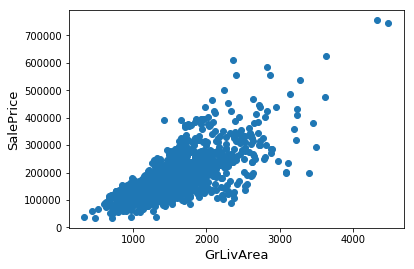

In [4]:
# Deleting outliers
train = train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index)

# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train["GrLivArea"], train["SalePrice"])
plt.ylabel("SalePrice", fontsize=13)
plt.xlabel("GrLivArea", fontsize=13)
plt.show()

## Statistical transformation

因為要使用回歸相關模型，所以要先確認一些假設是否符合

1.Target variable is right skewed.

2.Need to transform this variable and make it more normally distributed.

3.Log-transformation of the target variable


 mu = 180932.92 and sigma = 79467.79



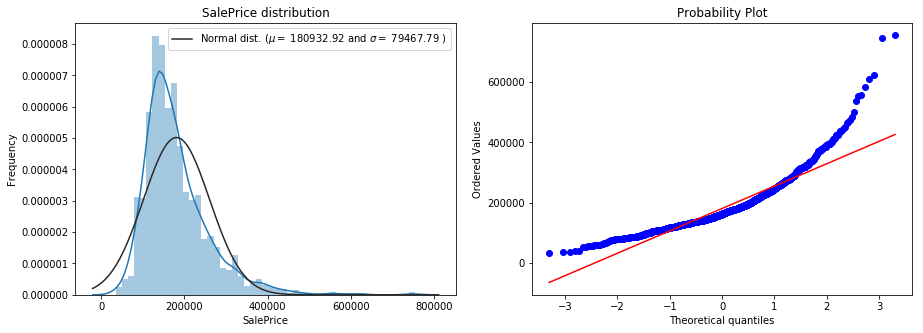

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(train["SalePrice"] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train["SalePrice"])
print( "\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

# Get also the QQ-plot
plt.subplot(1, 2, 2)
res = stats.probplot(train["SalePrice"], plot=plt)


 mu = 12.02 and sigma = 0.40



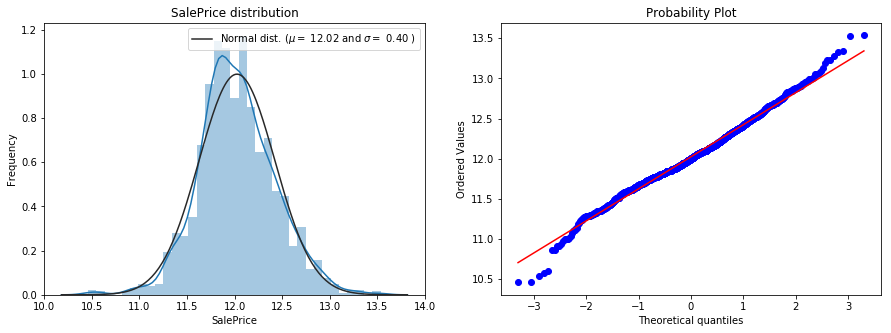

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

# Check the new distribution 
sns.distplot(train["SalePrice"] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train["SalePrice"])
print( "\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

plt.subplot(1, 2, 2)
res = stats.probplot(train["SalePrice"], plot=plt)

## 2. Feature Engineering

## Concat training and testing data

In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test), axis=0, sort=True).reset_index(drop=True)
all_data.drop(["SalePrice"], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


## Missing Value

- PoolQC 有三筆 "PoolQC" 為 NaN，但 "PoolArea" > 0，因此這三筆缺失值可以透過 OverallQual(4 Below Average, 6 Above Average, 3 Fair) --> (Fa, Gd, Fa)。其餘缺失值全部補上字串 None

In [9]:
# all_data[all_data["PoolArea"] > 0 & all_data["PoolQC"].isnull()][["PoolQC", "PoolArea", "OverallQual"]]
all_data.loc[2418, "PoolQC"] = "Fa"
all_data.loc[2501, "PoolQC"] = "Gd"
all_data.loc[2597, "PoolQC"] = "Fa"

In [10]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- MiscFeature 目前沒有想法怎麼處理，不排除刪掉

In [11]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- Alley 目前沒有想法怎麼處理，不排除刪掉

In [12]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- Fence 目前沒有想法怎麼處理，不排除刪掉

In [13]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- FireplaceQu 目前沒有想法怎麼處理，不排除刪掉

In [14]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- LotFrontage 由於每個地區距離街道應該會相似，所以利用相同變數 Neighborhood 的 LotFrontage 中位數來填補缺失值

In [15]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- XXXGarage 數值的欄位缺失值補 0，字串的欄位缺失值補 "None"
- 有兩筆 "GarageYrBlt" 為 NaN，但 GarageType"="Detchd"，因此這兩筆缺失值可以透過 中位數來回填。而其他 "GarageXXX" 數值的欄位缺失值補 中位數，字串的欄位缺失值補 "最常出現的"

In [16]:
# all_data[(all_data["GarageType"] == "Detchd") & all_data["GarageYrBlt"].isnull()]
all_data.loc[2124, "GarageYrBlt"] = all_data["GarageYrBlt"].median()
all_data.loc[2574, "GarageYrBlt"] = all_data["GarageYrBlt"].median()

all_data.loc[2124, "GarageFinish"] = all_data["GarageFinish"].mode()[0]
all_data.loc[2574, "GarageFinish"] = all_data["GarageFinish"].mode()[0]

all_data.loc[2574, "GarageCars"] = all_data["GarageCars"].median()

all_data.loc[2124, "GarageArea"] = all_data["GarageArea"].median()
all_data.loc[2574, "GarageArea"] = all_data["GarageArea"].median()

all_data.loc[2124, "GarageQual"] = all_data["GarageQual"].mode()[0]
all_data.loc[2574, "GarageQual"] = all_data["GarageQual"].mode()[0]

all_data.loc[2124, "GarageCond"] = all_data["GarageCond"].mode()[0]
all_data.loc[2574, "GarageCond"] = all_data["GarageCond"].mode()[0]

In [17]:
for col in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
    all_data[col] = all_data[col].fillna("None")

In [18]:
for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
    all_data[col] = all_data[col].fillna(0)

- BsmtFinXXX 做法跟 Garage 一樣

In [19]:
for col in ("BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF","TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)

In [20]:
for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
    all_data[col] = all_data[col].fillna("None")

- MasVnrType、MasVnrArea 目前沒有想法怎麼處理，不排除刪掉

In [21]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- Electrical 電子系統的等級

In [22]:
all_data["Electrical"] = all_data["Electrical"].fillna(all_data["Electrical"].mode()[0])

- MSZoning 房屋所在地的種類。工業、農地之類的。

In [23]:
all_data["MSZoning"] = all_data["MSZoning"].fillna(all_data["MSZoning"].mode()[0])

- Utilities 擁有的能源，瓦斯、水之類的。train 有一個 NoSeWa、test 有兩個 NA，其餘都是 AllPub。所以這變數好像沒啥用。

In [24]:
all_data = all_data.drop(["Utilities"], axis=1)

- Functional 感覺有點像是房屋是否有被法院保管或負載之類的

In [25]:
all_data["Functional"] = all_data["Functional"].fillna(all_data["Functional"].mode()[0])

- Exterior1st、Exterior2nd test 各有一個缺失值。其中一個類別特別多數量所以選擇利用該類別來回填缺失值

In [26]:
all_data["Exterior1st"] = all_data["Exterior1st"].fillna(all_data["Exterior1st"].mode()[0])
all_data["Exterior2nd"] = all_data["Exterior2nd"].fillna(all_data["Exterior2nd"].mode()[0])

- SaleType test 有一個缺失值

In [27]:
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])

- KitchenQual test 有一個缺失值

In [28]:
all_data["KitchenQual"] = all_data["KitchenQual"].fillna(all_data["KitchenQual"].mode()[0])

In [29]:
# Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing Ratio" :all_data_na})
missing_data.head()

,Missing Ratio


- 調整變數型態 e.g 有些明明是類別變數，但型態卻是整數..

In [30]:
### problem feature: 
# BedroomAbvGr、KitchenAbvGr、TotRmsAbvGrd
# BsmtFullBath、BsmtHalfBath、FullBath、HalfBath

# MSSubClass
all_data["MSSubClass"] = all_data["MSSubClass"].apply(str)

# OverallQual、OverallCond
# all_data["OverallQual"] = all_data["OverallQual"].apply(str)
# all_data["OverallCond"] = all_data["OverallCond"].apply(str)

# all_data["YearBuilt"] = all_data["YearBuilt"].apply(int)
# Feature about time
# GarageYrBlt、YearBuilt、YearRemodAdd、YrSold、MoSold
# all_data["YrSold"] = all_data["YrSold"].apply(str)
# all_data["MoSold"] = all_data["MoSold"].apply(str)

In [31]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 78 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            2917 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2917 non-null object
BsmtExposure     2917 non-null object
BsmtFinSF1       2917 non-null float64
BsmtFinSF2       2917 non-null float64
BsmtFinType1     2917 non-null object
BsmtFinType2     2917 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2917 non-null object
BsmtUnfSF        2917 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2917 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      29

## Check categorical feature

- 檢查數據是否集中在同一個類別，如果是，可能要刪除

In [32]:
object_features = []
for i in all_data.columns:
    if all_data[i].dtype == object:
        object_features.append(i)
        
nbr_categorical_features = all_data[object_features].apply(lambda x: len(np.unique(x)))
nbr_categorical_features.sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
MSSubClass       16
Exterior1st      15
Condition1        9
SaleType          9
HouseStyle        8
Condition2        8
BsmtFinType2      7
RoofMatl          7
Functional        7
GarageType        7
BsmtFinType1      7
FireplaceQu       6
Foundation        6
GarageCond        6
GarageQual        6
Heating           6
SaleCondition     6
RoofStyle         6
HeatingQC         5
BsmtQual          5
BsmtExposure      5
Electrical        5
ExterCond         5
BldgType          5
Fence             5
MiscFeature       5
MSZoning          5
LotConfig         5
BsmtCond          5
MasVnrType        4
PoolQC            4
ExterQual         4
LotShape          4
GarageFinish      4
LandContour       4
KitchenQual       4
Alley             3
LandSlope         3
PavedDrive        3
CentralAir        2
Street            2
dtype: int64

In [33]:
print(all_data["Street"].value_counts())
print("-----")
print(all_data["CentralAir"].value_counts())
print("-----")

all_data = all_data.drop(["Street"], axis=1)

Pave    2905
Grvl      12
Name: Street, dtype: int64
-----
Y    2721
N     196
Name: CentralAir, dtype: int64
-----


- 透過 Label Encoder 將一些有好壞順序的類別變數轉換成數字

In [34]:
from sklearn.preprocessing import LabelEncoder

cols = ("MSSubClass", "Alley", "LotShape", "LandSlope", "OverallQual", "OverallCond",
        "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure","BsmtFinType1", 
        "BsmtFinType2", "HeatingQC", "CentralAir", "KitchenQual", "Functional", "FireplaceQu",
        "GarageQual", "GarageCond", "GarageFinish", "PavedDrive", "PoolQC", "Fence") # , "YrSold", "MoSold"

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print("Shape all_data: {}".format(all_data.shape))

Shape all_data: (2917, 77)


## Creating features

In [35]:
# Adding total sq feet feature 
all_data["TotalSF"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"]
# Adding total bathroom: FullBath + BsmtFullBath + HalfBath + BsmtHalfBath
all_data["Totalbaths"] = (all_data["FullBath"] + all_data["BsmtFullBath"] + 
                          (0.5*all_data["HalfBath"]) + (0.5*all_data["BsmtHalfBath"]))

# all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
#                               all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
#                              all_data['WoodDeckSF'])


# simplified features
# all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
# all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# total rooms + bathroom:

In [36]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({"Skew" :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [37]:
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
from scipy import stats

skewed_features = skewness.index
# lam = 0.3
lambda_range = np.linspace(-2, 2, 100)
loglikelihood = np.zeros(lambda_range.shape, dtype=float)

for feat in skewed_features:
    for idx, lam in enumerate(lambda_range):
        data_shift = all_data[feat] + 1.0
        loglikelihood[idx] = stats.boxcox_llf(lam, data_shift)
    lam_best = lambda_range[loglikelihood.argmax()]
    all_data[feat] = boxcox1p(all_data[feat], round(lam_best, 2))
#     all_data[feat] = boxcox1p(all_data[feat], 0.3)
    print("Box-Cox transform feature:{}, lambda:{}".format(feat, round(lam_best, 2)))

#     all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform
Box-Cox transform feature:MiscVal, lambda:-2.0
Box-Cox transform feature:PoolArea, lambda:-2.0
Box-Cox transform feature:LotArea, lambda:0.14
Box-Cox transform feature:LowQualFinSF, lambda:-2.0
Box-Cox transform feature:3SsnPorch, lambda:-2.0
Box-Cox transform feature:LandSlope, lambda:-2.0
Box-Cox transform feature:KitchenAbvGr, lambda:-1.52
Box-Cox transform feature:BsmtFinSF2, lambda:-1.47
Box-Cox transform feature:EnclosedPorch, lambda:-1.31
Box-Cox transform feature:ScreenPorch, lambda:-2.0
Box-Cox transform feature:BsmtHalfBath, lambda:-2.0
Box-Cox transform feature:MasVnrArea, lambda:-0.26
Box-Cox transform feature:OpenPorchSF, lambda:0.02
Box-Cox transform feature:WoodDeckSF, lambda:-0.1
Box-Cox transform feature:1stFlrSF, lambda:-0.02
Box-Cox transform feature:LotFrontage, lambda:0.63
Box-Cox transform feature:GrLivArea, lambda:0.02
Box-Cox transform feature:TotalSF, lambda:0.3
Box-Cox transform feature:BsmtFinSF1, la

### Feature Selection

In [35]:
# all_data = all_data.drop(["GarageYrBlt", "YearBuilt", "YearRemodAdd", "YrSold", "MoSold"], axis=1)

In [38]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [39]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modeling

In [40]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import clone, BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [41]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=16).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

### Single Model

In [42]:
LR = make_pipeline(RobustScaler(), LinearRegression())

In [43]:
score = rmsle_cv(LR)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1223 (0.0088)



In [44]:
LR.fit(train.values, y_train)
coeffs = pd.DataFrame(list(zip(train.columns, LR.steps[1][1].coef_)), columns=["Predictors", "Coefficients"])
coeffs.sort_values(by="Coefficients", ascending=False)
# benchmark_model = LR.fit(train.values, y_train)

,Predictors,Coefficients
48,PoolArea,0.677376
76,Condition2_PosA,0.294911
204,RoofStyle_Shed,0.178358
162,MiscFeature_Gar2,0.171558
57,TotalSF,0.145916
198,RoofMatl_WdShngl,0.135583
165,MiscFeature_Shed,0.129095
189,Neighborhood_StoneBr,0.126943
89,Exterior1st_BrkFace,0.113121
154,MSZoning_FV,0.112073


Text(0, 0.5, 'Rmse')

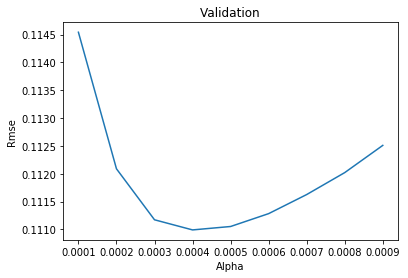

In [55]:
# Setting up list of alpha's
alphas = np.arange(start=0.0001, stop=0.001, step=0.0001)

# Iterate over alpha's
cv_lasso = [rmsle_cv(make_pipeline(RobustScaler(), Lasso(alpha=alpha, random_state=16))).mean() for alpha in alphas]

# Plot findings
cv_ridge = pd.Series(cv_lasso, index=alphas)
cv_ridge.plot(title="Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [56]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0004, random_state=16))

In [65]:
lasso.fit(train.values, y_train)
coeffs = pd.DataFrame(list(zip(train.columns, lasso.steps[1][1].coef_)), columns=["Predictors", "Coefficients"])
used_coeffs = coeffs[coeffs["Coefficients"] != 0].sort_values(by="Coefficients", ascending=False)
print(used_coeffs.shape)
print(used_coeffs)

(104, 2)
                Predictors  Coefficients
57                 TotalSF      0.135232
46             OverallQual      0.101362
189   Neighborhood_StoneBr      0.099624
173   Neighborhood_Crawfor      0.094596
30               GrLivArea      0.079491
54               YearBuilt      0.066253
89     Exterior1st_BrkFace      0.061426
183   Neighborhood_NridgHt      0.056797
182   Neighborhood_NoRidge      0.052804
50             ScreenPorch      0.052635
198       RoofMatl_WdShngl      0.051095
170   Neighborhood_BrkSide      0.045622
45             OverallCond      0.042915
59           BldgType_1Fam      0.039215
66         Condition1_Norm      0.036830
36                 LotArea      0.033949
217           SaleType_New      0.032552
25              GarageCars      0.030275
15              CentralAir      0.030076
149      LotConfig_CulDSac      0.025698
21              Fireplaces      0.024695
7               BsmtFinSF1      0.024470
209   SaleCondition_Normal      0.024002
55     

In [81]:
used_coeffs_values = train[used_coeffs["Predictors"]]
used_coeffs_values.shape

(1458, 104)

Text(0, 0.5, 'Rmse')

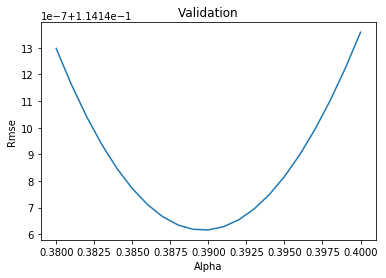

In [79]:
# Setting up list of alpha's
alphas = np.arange(start=0.38, stop=0.4, step=0.001)

# Iterate over alpha's
cv_ridge = [rmsle_cv(make_pipeline(RobustScaler(), KernelRidge(alpha=alpha, kernel="polynomial", degree=2, coef0=2.5))).mean() for alpha in alphas]

# Plot findings
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title="Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [113]:
KRR = make_pipeline(RobustScaler(), KernelRidge(alpha=0.39, kernel="polynomial", degree=2, coef0=2.5))

Text(0, 0.5, 'Rmse')

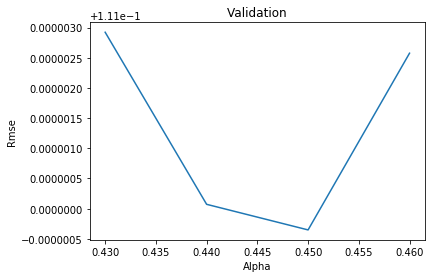

In [108]:
# Setting up list of alpha's
alphas = np.arange(start=0.00043, stop=0.00046, step=0.00001)
l1_ratios = np.arange(start=0.8, stop=1, step=0.05)

# Iterate over alpha's
cv_ENet = [rmsle_cv(make_pipeline(RobustScaler(), ElasticNet(alpha=alpha, l1_ratio=0.9, random_state=16))).mean() for alpha in alphas]
# cv_ENet = [rmsle_cv(make_pipeline(RobustScaler(), ElasticNet(alpha=0.00045, l1_ratio=l1_ratio, random_state=16))).mean() for l1_ratio in l1_ratios]

# Plot findings
cv_ridge = pd.Series(cv_ENet, index=alphas*1000)
cv_ridge.plot(title="Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [109]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00045, l1_ratio=.9, random_state=16))

In [116]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features="sqrt",
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss="huber", random_state=16)

In [118]:
RF = RandomForestRegressor(max_depth=30, n_estimators=500, max_features=100, oob_score=True, random_state=16)

In [110]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1110 (0.0070)



In [114]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1141 (0.0063)



In [115]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1110 (0.0070)



In [117]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1164 (0.0073)



In [119]:
score = rmsle_cv(RF)
print("RandomForest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

RandomForest score: 0.1316 (0.0050)



### Average single model

In [50]:
class AveragingModels(BaseEstimator):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(m) for m in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [51]:
# averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso, RF))

# score = rmsle_cv(averaged_models)
# print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

### Stacking Model

In [120]:
class StackingModels(BaseEstimator):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    def fit(self, X, y):
        self.base_models_ = [[] for m in self.base_models] # len(base_models) * n_folds
#         print("base_models_ shape:{}".format(np.array(self.base_models_).shape))
        
        self.meta_model_ = clone(self.meta_model)
#         print("meta_model_ shape:{}".format(np.array(self.meta_model_).shape))
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=16)
        
        oof_predictions = np.zeros((X.shape[0], len(self.base_models_)))
#         print("oof_predictions shape{}".format(oof_predictions.shape))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                oof_predictions[holdout_index, i] = y_pred
        
        self.meta_model_.fit(oof_predictions, y)
        return

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [121]:
stack_models = StackingModels(base_models=(ENet,GBoost,KRR), meta_model=lasso)
score = rmsle_cv(stack_models)
print("Stacking models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking models score: 0.1075 (0.0070)


## Submission

In [122]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [55]:
# averaged_models.fit(train.values, y_train)
# avg_model_train_pre = averaged_models.predict(train.values)
# avg_model_pre = averaged_models.predict(test.values)
# avg_model_pre = np.expm1(avg_model_pre)
# print(rmsle(y_train, avg_model_train_pre))

In [123]:
stack_models.fit(train.values, y_train)
print("start predict(train)")
stack_model_train_pre = stack_models.predict(train.values)
print(rmsle(y_train, stack_model_train_pre))
print("start predict(test)")
stack_model_pre = stack_models.predict(test.values)
stack_model_pre = np.expm1(stack_model_pre)

start predict(train)
0.07599868140971221
start predict(test)


In [124]:
sub = pd.DataFrame()
sub["Id"] = test_ID
sub["SalePrice"] = stack_model_pre
sub.to_csv("data/submission.csv", index=False)